# ADHunter mutagenesis


In [ ]:
import torch
# from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
import os
os.chdir("../adhunter")
import sys
sys.path.append("../src/")
import src

alphabet = src.get_alphabet()
aa_to_i, i_to_aa = src.get_encoding()

# load in AD data
fn = "../data/OrthologTilingDFwActivities_20240930_train_test_val.csv"
df = pd.read_csv(fn)
thresh = 80_000

# Load in model
model = src.load_model("adhunter_1he.pt")
model.eval()


/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


ActCNNSystem(
  (model): ActCNN(
    (emb): Linear(in_features=20, out_features=64, bias=False)
    (conv_init): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same)
    (res_blocks): ModuleList(
      (0-2): 3 x ResBlock(
        (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_1): ReLU()
        (conv_res): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same, dilation=(3,))
        (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_2): ReLU()
        (conv_block): Conv1d(64, 64, kernel_size=(1,), stride=(1,), padding=same)
      )
    )
    (pool): MaxPool1d(kernel_size=40, stride=40, padding=0, dilation=1, ceil_mode=False)
    (lin): Linear(in_features=64, out_features=1, bias=True)
  )
  (loss_fn): MSELoss()
  (rmse): MeanSquaredError()
  (pearsonr): PearsonCorrCoef()
  (spearmanr): SpearmanCorrCoef()
)

In [4]:
import copy
# np.random.seed(99)

def mut_step(seq):
    """For a given sequence, randomly replace an AA at each 
    position with another AA, then run ADHunter on all of 
    those sequences + the original and select the one with 
    the highest score

    Args:
        seq (torch.tensor): Starting sequence. Must be a 
        tensor of integers corresponding to AAs

    Returns:
        best_seq: highest scoring sequence
        best_score: highest score
    """    
    rand_seqs = [seq]
    for i in range(len(seq)):
        seq_i = copy.deepcopy(seq)
        seq_i[i] = np.random.randint(0, 20)
        rand_seqs.append(seq_i)

    rand_seqs = torch.tensor(np.vstack(rand_seqs))
    with torch.no_grad():
        rand_scores = model(rand_seqs)

    idxmax = torch.argmax(rand_scores)
    best_seq, best_score = rand_seqs[idxmax], rand_scores[idxmax]
    return best_seq, best_score


def run_mutagenesis(seq0 = None, n_iters=100):
    if type(seq0) == str:
        alphabet="ACDEFGHIKLMNPQRSTVWY"
        aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
        seq0 = torch.tensor([aa_to_i[i] for i in seq0])
    if seq0 is None:
        seq0 = torch.tensor(np.random.randint(0, 20, 40))
    with torch.no_grad():
        seqs, scores = [seq0], [model(seq0.unsqueeze(0))]
    seqs, scores
    for i in range(n_iters):
        seq_i, score_i = mut_step(seqs[-1])
        seqs.append(seq_i)
        scores.append(score_i)
    seqs = torch.vstack(seqs)
    scores = torch.concat(scores)
    return seqs, scores

In [5]:
def legend_kwargs():
    # Commonly used kwargs for figure legends
    kwargs = {
        "frameon" : False, 
        "bbox_to_anchor" : (1, 0.5), 
        "loc" : "center left"}
    return kwargs

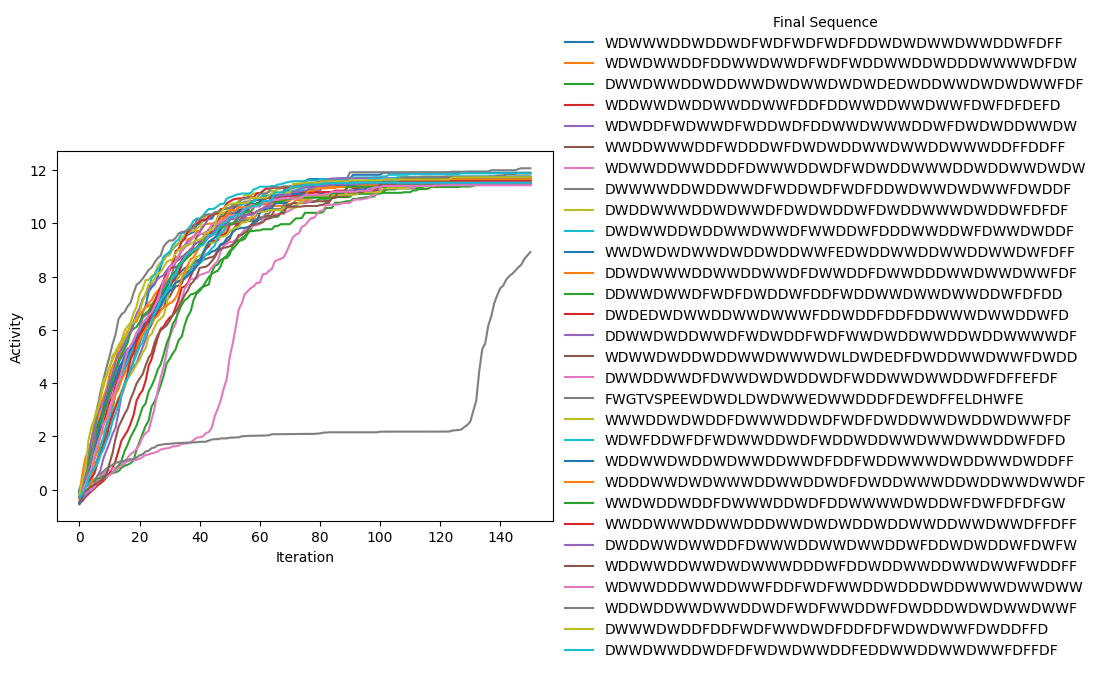

In [8]:
translator = lambda seq: "".join([i_to_aa[i] for i in seq.numpy()])


np.random.seed(42)
seqs_initial, scores, seqs_final = [], [], []
for _ in range(30):
    seed_seq = torch.tensor(np.random.randint(0, 20, 40))
    seqs_i, scores_i = run_mutagenesis(seed_seq, 150)
    seq_final = translator(seqs_i[-1])
    plt.plot(range(len(scores_i)), scores_i, label=seq_final)
    # Store stuff
    seqs_initial.append(translator(seed_seq))
    seqs_final.append(seq_final)
    scores.append(scores_i[-1].item())
plt.legend(title="Final Sequence", **legend_kwargs())
plt.ylabel("Activity")
plt.xlabel("Iteration")
plt.show()

In [9]:
result_df = pd.DataFrame(np.vstack([seqs_initial, seqs_final, scores]).T)
result_df.columns = ["initial_seq", "final_seq", "activity"]
result_df

,initial_seq,final_seq,activity
0,HYRMIHWMMEIDCNGCANNTLSRRWNYDFWHKHVEQVKCY,WDWWWDDWDDWDFWDFWDFWDFDDWDWDWWDWWDDWFDFF,11.899113655090332
1,KPRRFWYQTVDCALWTNANTDMTDIYEHQQESATLSSIHG,WDWDWWDDFDDWWDWWDFWDFWDDWWDDWDDDWWWWDFDW,11.548388481140137
2,DEGNWLATSKKKNKRCMMIGYHDIVTMCWHVIQHETFNKY,DWWDWWDDWDDWWDWDWWDWDWDEDWDDWWDWDWDWWFDF,11.629972457885742
3,IDEACPKNLLVNSGLRKCVNDHKIGAQSSEGRIAPVVPQM,WDDWWDWDDWWDDWWFDDFDDWWDDWWDWWFDWFDFDEFD,11.878174781799316
4,IAHCHHKEHYVPMKQIQTQFLGLMGLQYDHCHTPKPRPTI,WDWDDFWDWWDFWDDWDFDDWWDWWWDDWFDWDWDDWWDW,11.641514778137207
5,ATDVVCEALFFKQPPATYIDTNVQMSEVHMSSDKIHTMEE,WWDDWWWDDFWDDDWFDWDWDDWWDWWDDWWWDDFFDDFF,11.465432167053223
6,MEMKGTKGGEYMDVSSNQKHQYYLMHWWMGIAIFLCECRY,WDWWDDWWDDDFDWWWDDWDFWDWDDWWWDDWDDWWDWDW,11.558053016662598
7,SYLLYSYAMPVFEGRCEQEVYSKIMQTPIQMKIQRANFQS,DWWWWDDWDDWWDFWDDWDFWDFDDWDWWDWDWWFDWDDF,12.0664644241333
8,QDFGMWCNQKYSTTCLMDCEIWYVACILWHTDRETMGTLA,DWDDWWWDDWDWWDFDWDWDDWFDWDDWWWDWDDWFDFDF,11.453160285949707
9,CVDCAFHYEDGNSIMPQVIAETYGFQWQCKHVYMILVTTA,DWDWWDDWDDWWDWWDFWWDDWFDDDWWDDWFDWWDWDDF,11.875446319580078


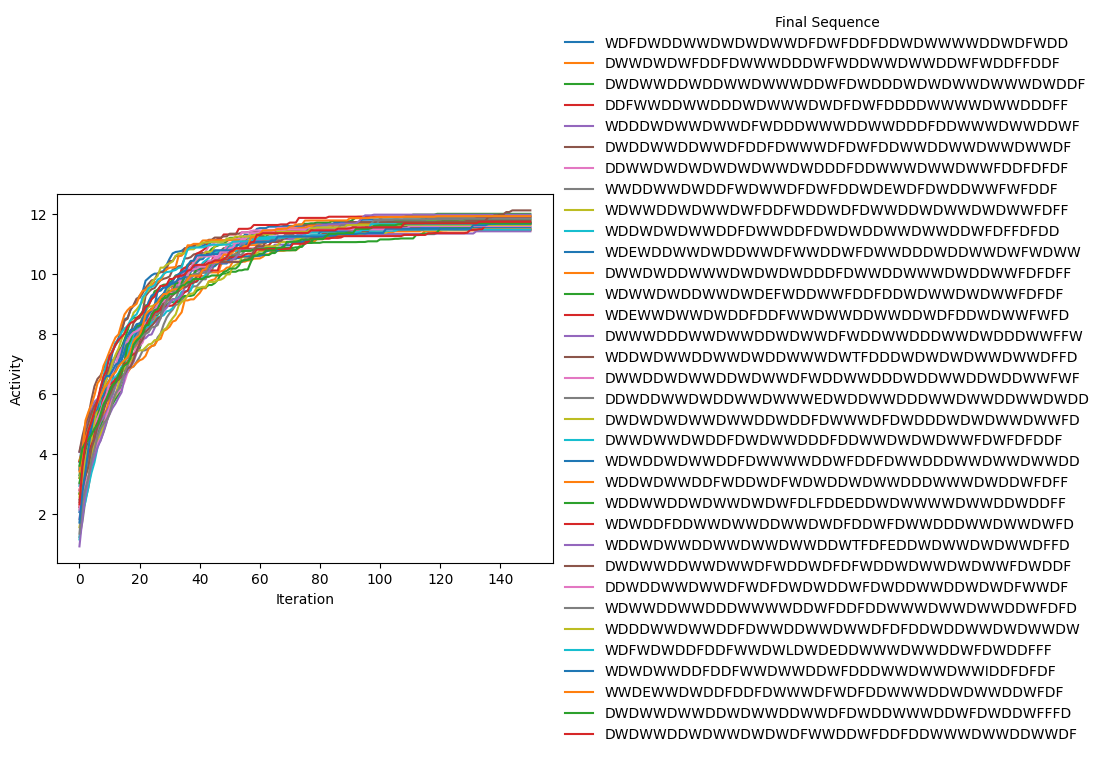

In [12]:
sdf = pd.read_csv("../data/SynAD_Glu_Filtered_ActivityCtrlStd_replicateactivities.csv")
sdf.sort_values(by="Activity", ascending=False, inplace=True)
amax = sdf["Activity"].max()
strong_synthetics = (torch.tensor(
    np.vstack(
        sdf.loc[sdf["Activity"] == amax, "AAseq"]
        .apply(lambda seq: np.array([aa_to_i[i] for i in seq]))
        .values)))


np.random.seed(42)
syn_seqs_initial, syn_scores, syn_seqs_final = [], [], []
for seed_seq in strong_synthetics:
    seqs_i, syn_scores_i = run_mutagenesis(seed_seq, 150)
    seq_final = translator(seqs_i[-1])
    plt.plot(range(len(syn_scores_i)), syn_scores_i, label=seq_final)
    # Store stuff
    syn_seqs_initial.append(translator(seed_seq))
    syn_seqs_final.append(seq_final)
    syn_scores.append(syn_scores_i[-1].item())
plt.legend(title="Final Sequence", **legend_kwargs())
plt.ylabel("Activity")
plt.xlabel("Iteration")
plt.show()

In [16]:
syn_act = model(strong_synthetics).detach().squeeze()
syn_result_df = pd.DataFrame(np.vstack([syn_seqs_initial, syn_act, syn_seqs_final, syn_scores]).T)
syn_result_df.columns = ["initial_seq", "initial_activity","final_seq", "activity"]
syn_result_df

,initial_seq,initial_activity,final_seq,activity
0,SFLALPDLEIYNFEPWDLPDFTTVGDFDGFSISDLRFLID,3.7508512,WDFDWDDWWDWDWDWWDFDWFDDFDDWDWWWWDDWDFWDD,11.517829895019531
1,SLPPLILPDMALENYEELSEIDQWLYLFDPFSWSELLKNI,2.679519,DWWDWDWFDDFDWWWDDDWFWDDWWDWWDDWFWDDFFDDF,11.46141242980957
2,MYPSIEDDDDVDDLLVDFSNDDDENIFPFFEEGDIRLWNF,3.3108516,DWDWWDDWDDWWDWWWDDWFDWDDDWDWDWWDWWWDWDDF,12.013096809387207
3,SASILNDVGVDDDDLNMDQDYDFSQFLEEFAPLLKLDAAC,2.2475548,DDFWWDDWWDDDWDWWWDWDFDWFDDDDWWWWDWWDDDFF,11.475397109985352
4,EFDDFNFEDYLTFFDETFDINELLGISSSNFVLDPSYSDQ,4.08136,WDDDWDWWDWWDFWDDDWWWDDWWDDDFDDWWWDWWDDWF,11.524744987487793
5,VNDAMVSLMFDVNDLDFLWESPIDESDPLVKEDLPDLFDY,3.2177854,DWDDWWDDWWDFDDFDWWWDFDWFDDWWDDWWDWWDWWDF,11.724876403808594
6,QEVFNFNGELEIENWELPSLEEENVDFLFHSFLELTQFPS,3.022027,DDWWDWDWDWDWDWWDWDDDFDDWWWDWWDWWFDDFDFDF,11.69775104522705
7,SGVTYNVGVEEDDDYLFDPKFAEKVPVLDPDSFVNEFLQV,1.2539791,WWDDWWDWDDFWDWWDFDWFDDWDEWDFDWDDWWFWFDDF,11.91352367401123
8,LLWGNDGDYDLSASLDIDEPHECFIDEDDILGFDYHVLIP,3.2074888,WDWWDDWDWWDWFDDFWDDWDFDWWDDWDWWDWDWWFDFF,11.828734397888184
9,MGAIDFDSWDAASRKDLIPEDSDILYKLHGSLGEELELGF,1.1692249,WDDWDWDWWDDFDWWDDFDWDWDDWWDWWDDWFDFFDFDD,11.724675178527832


## Why do these sequences get so many tryptophans?
DeepLIFT indicated that F was the most important residue, so I think it's odd that W's, not F's, are the main aromatic in these mutagenized sequences. 

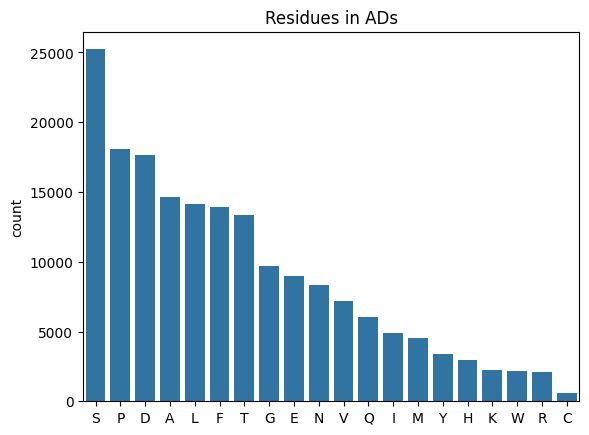

In [26]:
fn = "../data/OrthologTilingDFwActivities_20240930.csv"
# df = pd.read_csv(fn, index_col=0)
# df = df.loc[df.Activity != 0.0]
# # average over duplicates
# df = df.groupby("Seq").mean().reset_index()


df = pd.read_csv(fn)
df["Activity"] = df["Activity"].fillna(0.0)
df = df.loc[df.Activity != 0.0]
df = df.iloc[:, 1:]
df = df.loc[df.loc[:, ['Seq', 'Activity']].drop_duplicates().index]
# 
df = df.dropna(subset=df.columns[:-1], axis=0)
thresh = 80_000
ad_res_cts = pd.Series(list(df.loc[df["Activity"] >= thresh, "Seq"].sum())).value_counts()
sns.barplot(ad_res_cts)
plt.title("Residues in ADs")
plt.show()

/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_33508/3198476319.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x="W", y="Activity",
/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_33508/3198476319.py:6: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.boxplot(df, x="W", y="Activity",


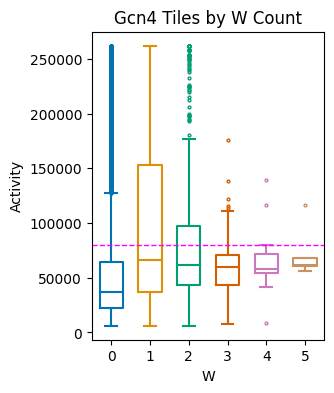

In [63]:
df["W"] = df["Seq"].str.count("W")
df_ad = df[df["Activity"] >= thresh]
# sns.boxplot(df_ad, x="W", y="Activity")
# sns.violinplot(df, x="W", y="Activity", palette=sns.color_palette("colorblind"))
plt.figure(figsize=(3,4))
sns.boxplot(df, x="W", y="Activity", 
            palette=sns.color_palette("colorblind"), width=.6, 
            fliersize=2, 
            fill=None)
# sns.stripplot(df, x="W", y="Activity")
plt.axhline(thresh, c='magenta', linewidth=1, linestyle="--")
plt.title("Gcn4 Tiles by W Count")
plt.show()